# Project Motivation

The goal is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Gathering Data for the project

Source 1. The twitter-archive-enhanced.csv file was provided. Here I am loading the file into a pandas dataframe.

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
678,789268448748703744,NaN,NaN,2016-10-21 00:53:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stella. She's happier than I will ever...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789268448...,10,10,Stella,None,None,None,None


Source 2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

The file is tab separated so the sep='\t' had to be used to correctly load the file into the dataframe.

In [4]:
prediction_file_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [5]:
response = requests.get(prediction_file_url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [6]:
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [7]:
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1340,758740312047005698,https://pbs.twimg.com/media/CoeWSJcUIAAv3Bq.jpg,1,Chesapeake_Bay_retriever,0.848514,True,Labrador_retriever,0.110054,True,curly-coated_retriever,0.025201,True


Source 3. Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [8]:
import tweepy
from settings import *
import json

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

I very frequently run the df.sample to have as reference.

In [9]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2243,667902449697558528,NaN,NaN,2015-11-21 03:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cleopatricia. She is a northern Paperb...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667902449...,9,10,Cleopatricia,None,None,None,None


Here I start to do the actual pull of tweets needed. 

I am looping through the tweet_ids on the archive dataframe, getting the data from the api and then save it to the file. I am saving the exceptions into a list just for reference.

Note: This execution took about 40 minutes to run because twitter has API rate limits. 

In [ ]:
start = time.time()
exceptions = []
file_exception = False
for tweet_id in twitter_archive.tweet_id:    
    print(tweet_id)
    try:       
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        with open('tweet_json.txt', 'a') as outfile:
            try:
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except:
                file_exception = True
                print('file exception')
    except:
        exceptions.append(tweet_id)
        print('tweet exception')
            
    end = time.time()
    print(end - start)

I loaded the file into a dataframe using the pd.read_json function and then got a sample to confirm it was loaded as expected.

In [10]:
df = pd.read_json('tweet_json.txt', lines=True)
df.sample()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
940,2016-07-06 01:46:38+00:00,750506206503038976,750506206503038976,This is Malcolm. He's absolutely terrified of ...,False,"[0, 80]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 750506196939972608, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


Finally, I created a copy of the dataframe and then left only the columns I was interested in keeping.

In [11]:
tweet_details_df = df.copy()

In [12]:
tweet_details_df = tweet_details_df[['id', 'retweet_count', 'favorite_count']]

In [14]:
tweet_details_df.sample()

,id,retweet_count,favorite_count
321,832645525019123713,535,2951


## Assessing data for the project

#### Data quality Dimensions
- Completeness
- Validity
- Accuracy
- Consistency

#### Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data. Tidy data requirements:

- Each variable forms a column.

- Each observation forms a row.

- Each type of observational unit forms a table.

<font color='green' size='4'>
twitter-archive-enhanced dataset

##### Quality issues

- There are about 2000 records that are not classified as either doggo, floofer, pupper, puppo. In other words the 4 columns are set as None for about 2000 records.
- There are 59 records without associated image.
- There are 181 retweets that from this dataset perspective would be considered duplicate records.
- About 800 records have an inaccurate name. 745 set up as None and 55 set up as 'a'.
- There is a record that has both doggo and floofer. It should only be floofer.
- Records with denominator different than 10
- Records with numerator far from the median.
- Numerator should be 11 instead of 27. Ideally it should be 11.27 but for this exercise I will leave it as 11 because most of the numbers are integers.¶

##### Tidiness

- The columns doggo, floofer, pupper and puppo should be one column because it is one variable.

#### Getting acquainted with the dataset

In [15]:
twitter_archive.shape

(2356, 17)

In [16]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
116,870308999962521604,NaN,NaN,2017-06-01 16:00:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Rumble, but he's not ready to. Would r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/870308999...,13,10,Rumble,None,None,None,None


In [17]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [18]:
twitter_archive.in_reply_to_status_id.value_counts().count()

77

AS you can see some rows have multiple dog stages. To clean this step you need to combine all the stages into a single column. These multiple stages can be represented as doggo, pupper in the new column with stages delimited by comma or using
a single value like multiple.

Merge Dog stages.

Here is an approach to solve this.

- Set the None values to np.nan in all the 4 dog stage columns.
- Concatenate all 4 columns to 1 column dog_stage
- Now the multiple dog stages rows will have values combined. So replace them with code
- Remove the original 4 columns of dog stages.
Hope this helps .

In [135]:
twitter_archive.loc[(twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377

#### Quality Issue. There are 59 records without associated image. Used expanded_urls.isnull() to identify the tweets without images.

In [19]:
twitter_archive.expanded_urls.isnull().sum()

59

In [20]:
twitter_archive[twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


#### Quality Issue. There are 181 retweets that from this dataset perspective would be considered duplicate records. Used query('retweeted_status_id != "NaN"') to identify tweets that were retweets.

In [21]:
twitter_archive.query('retweeted_status_id != "NaN"').tweet_id.count()

181

In [22]:
twitter_archive.query('retweeted_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


#### Quality Issue. There are almost 2000 records out of 2356 that do not have a dog stage. Used .query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"') to identify them.

In [23]:
twitter_archive.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"').tweet_id.count()

1976

#### Quality Issue. This should only be floof, not doggo. Used .query('floofer == "floofer" and doggo == "doggo"') to see the tweet. I found this during the visualization in Excel.
Complete tweet: At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs

In [24]:
twitter_archive.query('floofer == "floofer" and doggo == "doggo"')[['text']]

,text
200,"At first I thought this was a shy doggo, but i..."


#### Quality Issue. Records with denominator different than 10

In [25]:
twitter_archive.query('rating_denominator != 10').tweet_id.count()

23

##### Quality Issue. One by one analyze records with denominator different than 10

In [26]:
twitter_archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


#### Quality Issue. Records with numerator away from the median.

Picked the 15 kind of randomly as a number 

In [27]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [28]:
twitter_archive.query('rating_numerator > 15').tweet_id.count()

26

#### Quality Issue. Name accuracy. There are more than 800 names that are clearly not well defined: None or a.

In [29]:
twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
          ... 
Bertson      1
Creg         1
Venti        1
Edd          1
Jonah        1
Name: name, Length: 957, dtype: int64

In [31]:
twitter_archive.query('name in ["None", "a"]').sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None


#### Tidiness issue. The columns doggo, floofer, pupper and puppo should be one column insted of four because it is one variable. Here I ran a query to give a glance to the data structure for values where the pup_stage columns are different than None.

In [32]:
(twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']]
 .query('doggo != "None" or floofer != "None" or pupper != "None" or puppo != "None"'))

,doggo,floofer,pupper,puppo
9,doggo,None,None,None
12,None,None,None,puppo
14,None,None,None,puppo
29,None,None,pupper,None
43,doggo,None,None,None
...,...,...,...,...
1995,None,None,pupper,None
2002,None,None,pupper,None
2009,None,None,pupper,None
2015,None,None,pupper,None


 #### Quality Issue. Numerator should be 11 instead of 27. Ideally it should be 11.27 but for this exercie will leave it as 11 because most of the numbers are integers. 
 Here my logic to find this issue was that I wanted to find tweets that had a dog_stage and were outliers with regards of the rating.

In [35]:
(twitter_archive
 .query('(doggo != "None" or floofer != "None" or pupper != "None" or puppo != "None") and rating_numerator >= 15'))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None


I change this setting in case I needed to see more complete tweets text descriptions.

In [36]:
pd.options.display.max_colwidth = 200

<font color='green' size='4'>
image_predictions dataset

#### Data quality Dimensions
- Completeness
- Validity
- Accuracy
- Consistency

#### Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data. Tidy data requirements:

- Each variable forms a column.

- Each observation forms a row.

- Each type of observational unit forms a table.

##### Quality issues

- Pass

##### Tidiness

- The predictions are not in the master dataset.

Getting aquainted to the dataset and do visual and programatically assessment.

In [37]:
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1422,772114945936949249,https://pbs.twimg.com/media/Crcacf9WgAEcrMh.jpg,1,Chihuahua,0.803293,True,toy_terrier,0.05298,True,Italian_greyhound,0.037239,True


In [38]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [39]:
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [40]:
image_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
agama                   1
convertible             1
swab                    1
banana                  1
ice_lolly               1
Name: p1, Length: 378, dtype: int64

In [41]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [42]:
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [44]:
image_predictions.tweet_id.duplicated().sum()

0

<font color='green' size='4'>
tweet_details_df dataset

#### Data quality Dimensions
- Completeness
- Validity
- Accuracy
- Consistency

#### Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data. Tidy data requirements:

- Each variable forms a column.

- Each observation forms a row.

- Each type of observational unit forms a table.

##### Quality issues

- Pass

##### Tidiness

- The details are not in the master dataset.

Getting aquainted to the dataset and do visual and programatically assessment.

In [45]:
tweet_details_df.sample()

,id,retweet_count,favorite_count
1439,694669722378485760,14330,35725


In [46]:
tweet_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [47]:
tweet_details_df.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2707.513085,7569.226083
std,6.823170e+16,4578.311885,11747.116239
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,548.000000,1319.500000
50%,7.182469e+17,1269.000000,3293.000000
75%,7.986692e+17,3146.000000,9264.500000
max,8.924206e+17,77917.000000,156349.000000


In [48]:
tweet_details_df.id.duplicated().sum()

0

## Cleaning

<font color='green' size='4'>
twitter-archive-enhanced dataset

##### Quality issues

- (Not selected to be fixed during this exercise). There are about 2000 records that are not classified as either doggo, floofer, pupper, puppo. In other words the 4 columns are set as None for about 2000 records.
- Remove the 59 records without associated image.
- Remove the 181 retweets that from this dataset perspective would be considered duplicate records.
- Set to None the records that start with a lowercase letter. That way the records with unknown name will all be set up to None.
- Change to floofer the record that has both fluffer and doggo.
- Records with denominator different than 10.
- Records with numerator far from the median.
        Correct tweet_id record 740373189193256964. The numerator and denominator should be 14/10.
        Correct tweet_id 722974582966214656. The numerator and denominator should be 13/10.
        Correct tweet_id 666287406224695296. The numerator and denominator should be 9/10.
- Numerator should be 11 instead of 27. Ideally it should be 11.27 but for this exercise I will leave it as 11 because most of the numbers are integers.¶

##### Tidiness

- The columns doggo, floofer, pupper and puppo should be one column because it is one variable.

#### Getting acquainted with the dataset

In [49]:
twitter_archive.shape

(2356, 17)

In [50]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Beau. He's trying to keep his daddy from packing to leave for Annual Training. 13/10 and now I'm crying https://t.co/7JeDfQvzzI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750041628174217216/photo/1,13,10,Beau,None,None,None,None


In [51]:
twitter_archive_cp = twitter_archive.copy()

### Fixing Quality Issues 

#### 1. Remove the 59 records without associated image.

In [52]:
twitter_archive_cp.expanded_urls.isnull().sum()

59

Code

In [53]:
twitter_archive_cp = twitter_archive_cp[~twitter_archive_cp.expanded_urls.isnull()]

Test. There are no records with expanded_urls as null.

In [54]:
twitter_archive_cp.expanded_urls.isnull().sum()

0

#### 2. Remove the ~181 retweets that from this dataset perspective would be considered duplicate records. 

In [55]:
twitter_archive_cp.retweeted_status_id.isna().sum()

2117

Code

In [56]:
twitter_archive_cp = twitter_archive_cp[twitter_archive_cp.retweeted_status_id.isna()]

Test. No more records with retweet status exist in the dataset.

In [57]:
twitter_archive_cp.retweeted_status_id.notna().sum()

0

#### 3. Replace all the names which start with a lowercase letter to 'None'

In [58]:
twitter_archive_cp[twitter_archive_cp.name.str.contains('^[a-z][\w]*')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None


Code

In [59]:
twitter_archive_cp.name = twitter_archive_cp.name.str.replace(r'(^[a-z][\w]*)', 'None')

Test. There are no records which start with a lowercase letter

In [60]:
twitter_archive_cp[twitter_archive_cp.name.str.contains('^[a-z][\w]*')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### 4. Change to only doggo the record that has both fluffer and doggo. The word floofer was used to mention an owl.

In [61]:
twitter_archive_cp.query('floofer == "floofer" and doggo == "doggo"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None


Code

In [62]:
twitter_archive_cp.loc[200, 'floofer'] = 'None'

Test

In [63]:
twitter_archive_cp.query('floofer == "floofer" and doggo == "doggo"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### 5. Remove records which description does not include a rating. Once the results were analyzed, that would be records 516 and 1662.

In [64]:
twitter_archive_cp.query('rating_denominator != 10')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


Code

In [65]:
drop_list = [516, 1662]

In [66]:
twitter_archive_cp.drop(drop_list, inplace=True)

Test. The records 516 and 1662 no longer exist.

In [67]:
twitter_archive_cp.query('rating_denominator != 10')[['tweet_id','text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50


#### 6. Correct tweet_id record 740373189193256964. The numerator and denominator should be 14/10.

Code

In [68]:
mask = twitter_archive_cp.tweet_id == 740373189193256964
twitter_archive_cp.loc[mask, 'rating_numerator'] = 14
twitter_archive_cp.loc[mask, 'rating_denominator'] = 10

Test

In [69]:
twitter_archive_cp[twitter_archive_cp['tweet_id'] == 740373189193256964]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http...",14,10,None,None,None,None,None


#### 7. Correct tweet_id 722974582966214656. The numerator and denominator should be 13/10.

In [70]:
twitter_archive_cp[twitter_archive_cp['tweet_id'] == 722974582966214656]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None


Code

In [71]:
mask = twitter_archive_cp.tweet_id == 722974582966214656
twitter_archive_cp.loc[mask, 'rating_numerator'] = 13
twitter_archive_cp.loc[mask, 'rating_denominator'] = 10

Test

In [72]:
twitter_archive_cp[twitter_archive_cp['tweet_id'] == 722974582966214656]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13,10,None,None,None,None,None


#### 8. Correct tweet_id 666287406224695296. The numerator and denominator should be 9/10.

Code

In [73]:
mask = twitter_archive_cp.tweet_id == 666287406224695296
twitter_archive_cp.loc[mask, 'rating_numerator'] = 9
twitter_archive_cp.loc[mask, 'rating_denominator'] = 10

Test

In [74]:
twitter_archive_cp[twitter_archive_cp['tweet_id'] == 666287406224695296]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,None,None,None,None,None


#### 9. Numerator should be 11 instead of 27. Ideally it should be 11.27 but for this exercise I will leave it as 11 because most of the numbers are integers.

In [75]:
twitter_archive_cp.query('rating_numerator == 27')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None


Code

In [76]:
mask = twitter_archive_cp.tweet_id == 778027034220126208
twitter_archive_cp.loc[mask, 'rating_numerator'] = 11

Test

In [77]:
twitter_archive_cp.loc[mask]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11,10,Sophie,None,None,pupper,None


### Fixing Tidy Issues

#### Tidy issue 1. The columns doggo, floofer, pupper and puppo should be one column because it is one variable.

In [78]:
def dog_stage(tweet):
    try:
        if tweet.doggo == 'doggo':
            return 'doggo'
        elif tweet.floofer == 'floofer':
            return 'floofer'
        elif tweet.pupper == 'pupper':
            return 'pupper'
        elif tweet.puppo == 'puppo':
            return 'puppo'
        else:
            return 'None'
    except:
        return 'None'

In [79]:
twitter_archive_cp['dog_stage'] = twitter_archive_cp.apply(dog_stage, axis=1)

In [80]:
twitter_archive_cp = twitter_archive_cp.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'])

In [81]:
twitter_archive_cp.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
88,875097192612077568,NaN,NaN,2017-06-14 21:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You'll get your package when that precious man is done appreciating the pups. 13/10 for everyone https://t.co/PFp4MghzBW,NaN,NaN,NaN,https://twitter.com/drboondoc/status/874413398133547008,13,10,None,None
380,827600520311402496,NaN,NaN,2017-02-03 19:31:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Tucker. It's his birthday. He's pupset with you because you're too busy playing @GoodDogsGame to celebrate. 13/10 would put down phone https://t.co/vrppizPGdb,NaN,NaN,NaN,https://twitter.com/dog_rates/status/827600520311402496/photo/1,13,10,Tucker,None
1383,700847567345688576,NaN,NaN,2016-02-20 01:00:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Crouton. He's a Galapagos Boonwiddle. Has a legendary tongue (most Boonwiddles do). Excellent stuff 10/10 https://t.co/110Eeg7KW3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700847567345688576/photo/1,10,10,Crouton,None


In [82]:
twitter_archive_cp.shape

(2115, 14)

#### Tidy issue 2. Retweet and favorite statistics should be merged into the twitter_archive dataset

In [83]:
tweet_details_df.sample()

,id,retweet_count,favorite_count
594,796904159865868288,9146,0


Changed the column name so they would match

In [84]:
tweet_details_df.rename(columns={"id": "tweet_id"}, inplace=True)

Executed the merge 

In [109]:
twitter_archive_clean = pd.merge(twitter_archive_cp, tweet_details_df,
                                on=['tweet_id'], how='left')

In [110]:
twitter_archive_clean.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
1970,668625577880875008,NaN,NaN,2015-11-23 03:02:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Maks. Maks just noticed something wasn't right. 10/10 https://t.co/0zBycaxyvs,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668625577880875008/photo/1,10,10,Maks,None,123.0,370.0
1027,712085617388212225,NaN,NaN,2016-03-22 01:16:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Olive and Ruby. They are best buddies. Both 11/10 \n1 like = 1 buddy https://t.co/yagmFdKlyL,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/712085617388212225/photo/1,https://twitter.com/dog_rates/status/712085617388212225/photo/1,https://twitter.com/dog_rates/status/712085617388212225/photo/1",11,10,Olive,None,484.0,3256.0


Found that there were some records set as NaN and were set to 0. Then changed the datatype to int

In [111]:
twitter_archive_clean.query('retweet_count == "NaN" or favorite_count == "NaN"').tweet_id.count()

7

In [112]:
twitter_archive_clean.retweet_count = twitter_archive_clean.retweet_count.fillna(0).astype(int)

In [113]:
twitter_archive_clean.favorite_count = twitter_archive_clean.favorite_count.fillna(0).astype(int)

In [114]:
twitter_archive_clean.query('retweet_count == "NaN" or favorite_count == "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count


Test

In [115]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2114
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2115 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2115 non-null   object 
 4   source                      2115 non-null   object 
 5   text                        2115 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2115 non-null   object 
 10  rating_numerator            2115 non-null   int64  
 11  rating_denominator          2115 non-null   int64  
 12  name                        2115 non-null   object 
 13  dog_stage                   2115 

In [116]:
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
913,700864154249383937,https://pbs.twimg.com/media/Cbn4OqKWwAADGWt.jpg,1,kuvasz,0.805857,True,Great_Pyrenees,0.187272,True,Samoyed,0.003491,True


In [117]:
image_predictions.shape

(2075, 12)

#### Tidy issue 3. Include image predictions into the twitter archive dataset

Executed the merge and review a sample record as quick glance of the result using .sample and .columns fucntions.

In [118]:
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions,
                                on=['tweet_id'], how='left')

In [119]:
twitter_archive_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2113,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,...,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.07201,True


In [120]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'retweet_count',
       'favorite_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

Changed the datatype of img_num to int.

In [121]:
twitter_archive_clean.img_num = twitter_archive_clean.img_num.fillna(0).astype(int)

Reviewed the .info to decide which columns to drop

In [122]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2114
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2115 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2115 non-null   object 
 4   source                      2115 non-null   object 
 5   text                        2115 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2115 non-null   object 
 10  rating_numerator            2115 non-null   int64  
 11  rating_denominator          2115 non-null   int64  
 12  name                        2115 non-null   object 
 13  dog_stage                   2115 

Dropped the columns that I did not want to keep

In [123]:
twitter_archive_clean = twitter_archive_clean.drop(columns = ['in_reply_to_status_id',
                                                              'in_reply_to_user_id',
                                                              'retweeted_status_id', 
                                                              'retweeted_status_user_id',
                                                              'retweeted_status_timestamp'])

Test

In [124]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2114
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2115 non-null   int64  
 1   timestamp           2115 non-null   object 
 2   source              2115 non-null   object 
 3   text                2115 non-null   object 
 4   expanded_urls       2115 non-null   object 
 5   rating_numerator    2115 non-null   int64  
 6   rating_denominator  2115 non-null   int64  
 7   name                2115 non-null   object 
 8   dog_stage           2115 non-null   object 
 9   retweet_count       2115 non-null   int64  
 10  favorite_count      2115 non-null   int64  
 11  jpg_url             1992 non-null   object 
 12  img_num             2115 non-null   int64  
 13  p1                  1992 non-null   object 
 14  p1_conf             1992 non-null   float64
 15  p1_dog              1992 non-null   object 
 16  p2    

### Insights

I usually run .sample() to have as reference

In [125]:
twitter_archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1271,692894228850999298,2016-01-29 02:17:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Tupawc. He's actually a Christian rapper. Doesn't even understand the concept of dollar signs. 10/10 great guy https://t.co/mCqgtqLDCW,https://twitter.com/dog_rates/status/692894228850999298/photo/1,10,10,Tupawc,None,804,...,1,German_short-haired_pointer,0.876977,True,bluetick,0.036615,True,basset,0.017848,True


I created a boxplot of the p1 variable, the first prediction confidence provided in the dataset just to visualize the distribution of the ranges of the values.

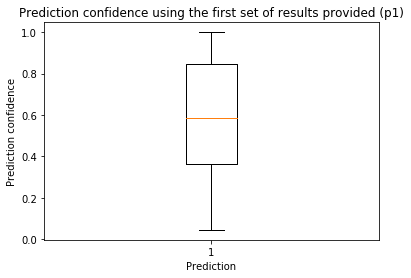

In [126]:
plt.boxplot(twitter_archive_clean[twitter_archive_clean.p1_conf.notna()]['p1_conf']);
plt.title('Prediction confidence using the first set of results provided (p1)')
plt.xlabel('Prediction')
plt.ylabel('Prediction confidence');

I also ran the describe because it gives a good idea about the statistics of the numeric values.

In [127]:
twitter_archive_clean.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2.115000e+03,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000,1992.000000,1.992000e+03,1.992000e+03
mean,7.363162e+17,12.245863,10.501182,2498.179196,8276.905910,1.133333,0.593960,1.344581e-01,6.021890e-02
std,6.706619e+16,40.290984,7.103397,4390.793427,12079.214074,0.613009,0.271928,1.007064e-01,5.086737e-02
min,6.660209e+17,0.000000,10.000000,0.000000,0.000000,0.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.766157e+17,10.000000,10.000000,554.000000,1828.000000,1.000000,0.362903,5.401683e-02,1.616933e-02
50%,7.094095e+17,11.000000,10.000000,1212.000000,3778.000000,1.000000,0.587635,1.174550e-01,4.950530e-02
75%,7.871428e+17,12.000000,10.000000,2850.500000,10300.000000,1.000000,0.845599,1.952647e-01,9.157912e-02
max,8.924206e+17,1776.000000,170.000000,77917.000000,156349.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


I proceeded to draw histograms of the ratings. First using all the tweets. Then using the tweets that were more retweeted. And lastly the tweets that were more favorited.

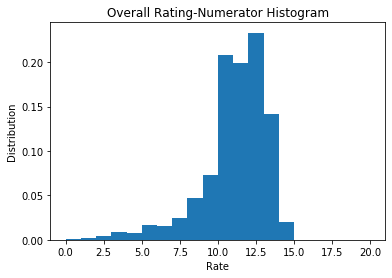

In [128]:
plt.hist(twitter_archive_clean.rating_numerator, bins=20, density=1, range=(0,20))
plt.title('Overall Rating-Numerator Histogram')
plt.xlabel('Rate')
plt.ylabel('Distribution');

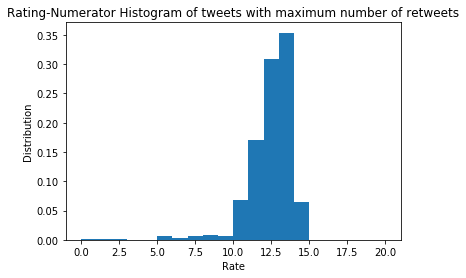

In [129]:
retweet_count_upper_75_percentile = twitter_archive_clean[twitter_archive_clean.retweet_count > 2850]['rating_numerator']
plt.hist(retweet_count_upper_75_percentile, bins=20, density=1, range=(0,20))
plt.title('Rating-Numerator Histogram of tweets with maximum number of retweets')
plt.xlabel('Rate')
plt.ylabel('Distribution');

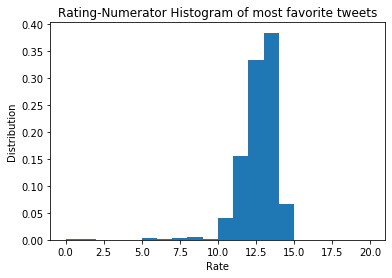

In [130]:
rating_numerator_most_favorited_tweets = twitter_archive_clean[twitter_archive_clean.favorite_count >10300]['rating_numerator']
plt.hist(rating_numerator_most_favorited_tweets, bins=20, density=1, range=(0,20))
plt.title('Rating-Numerator Histogram of most favorite tweets')
plt.xlabel('Rate')
plt.ylabel('Distribution');

I was curious about seeing which dog stage was more prevalent. So I draw a histogram of the dog_stage without the 'None'

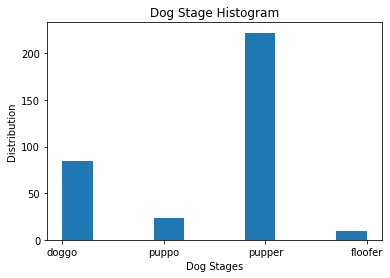

In [131]:
plt.hist(twitter_archive_clean[twitter_archive_clean.dog_stage != 'None']['dog_stage'])
plt.title('Dog Stage Histogram')
plt.xlabel('Dog Stages')
plt.ylabel('Distribution');

I executed the value_counts on the first of the predictions (p1) to glimpse into the most prevalent prediction found.

In [132]:
twitter_archive_clean.p1.value_counts()

golden_retriever       138
Labrador_retriever      95
Pembroke                88
Chihuahua               79
pug                     54
                      ... 
agama                    1
convertible              1
American_black_bear      1
beaver                   1
slug                     1
Name: p1, Length: 374, dtype: int64

This last steps are to save the final dataset into a csv file and then to a validation to confirm that the file was loaded correctly by loading it back into a dataframe.

In [133]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

In [134]:
test = pd.read_csv('twitter_archive_master.csv')
test.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
372,815990720817401858,2017-01-02 18:38:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p,"https://www.gofundme.com/surgeryforjacktheminpin,https://twitter.com/dog_rates/status/815990720817401858/photo/1",11,10,Jack,None,1043,...,1,Chihuahua,0.428756,True,miniature_pinscher,0.103912,True,Staffordshire_bullterrier,0.088959,True
